# setup

From a terminal session:


```
# install dependencies
pip install upsetplot

# ensure gcloud installed: see https://cloud.google.com/sdk/docs/quickstart-linux
gcloud --version

# install our nacent client lib

git clone https://github.com/anvilproject/client-apis
cd client-apis/
git checkout pyAnVIL
pip install -e .

# execute the command line, it will give you a oauth prompt
python  pyAnVIL/anvil/cli.py


```








In [14]:
from anvil import anvil
import sys

def projects_with_schemas(namespace='anvil-datastorage', project_pattern='AnVIL.*CMG.*'):
    """Should return projects."""
    # get all matching projects in the namespace
    projects = anvil.get_projects([namespace], project_pattern=project_pattern)
    assert len(projects) > 0, "Should have at least 1 project in {} matching {}".format(namespace, project_pattern)
    # add the project schema
    projects = [anvil.get_project_schema(p) for p in projects]
    for p in projects:
        if len(p.schema.keys()) == 0:
            print('{} missing schema'.format(p.project), file=sys.stderr)
    # trim projects without schemas        
    projects = [p for p in projects if len(p.schema.keys()) > 0]
    return projects
        
projects = projects_with_schemas()

print([p.project for p in projects])

        

['AnVIL_CMG_Broad_Muscle_KNC_WGS', 'AnVIL_CMG_Broad_Orphan_VCGS-White_WES', 'AnVIL_CMG_Broad_Muscle_Myoseq_WES', 'AnVIL_CMG_Broad_Heart_Ware_WES', 'AnVIL_CMG_Broad_Muscle_Beggs_WES', 'AnVIL_CMG_Broad_Orphan_Estonia-Ounap_WES', 'AnVIL_CMG_Broad_Eye_Pierce_WES', 'AnVIL_CMG_Broad_Orphan_Estonia-Ounap_WGS', 'AnVIL_CMG_Broad_Muscle_Topf_WES', 'AnVIL_CMG_Broad_Blood_Sankaran_WES', 'AnVIL_CMG_Broad_Brain_Walsh_WES', 'AnVIL_CMG_Broad_Muscle_Kang_WES', 'AnVIL_CMG_Broad_Kidney_Hildebrandt_WES', 'AnVIL_CMG_Broad_Muscle_OGrady_WES', 'AnVIL_CMG_Broad_Brain_Gleeson_WES', 'AnVIL_CMG_Broad_Kidney_Hildebrandt_WGS', 'AnVIL_CMG_Broad_Orphan_Manton_WES', 'AnVIL_CMG_Broad_Heart_PCGC-Tristani_WGS', 'AnVIL_CMG_Broad_Muscle_KNC_WES', 'AnVIL_CMG_Broad_Heart_Seidman_WES', 'AnVIL_CMG_Broad_Muscle_Bonnemann_WGS', 'AnVIL_CMG_Broad_Muscle_Bonnemann_WES', 'AnVIL_CMG_Broad_Orphan_Manton_WGS', 'AnVIL_CMG_Broad_Muscle_Ravenscroft_WES', 'AnVIL_CMG_Broad_Orphan_VCGS-White_WGS', 'AnVIL_CMG_Broad_Muscle_Myoseq_WGS', 'AnVIL

AnVIL_CMG_Broad_Blood_Gazda_WGS missing schema
AnVIL_CMG_Broad_Blood_Gazda_WES missing schema


In [15]:
len(projects)

28

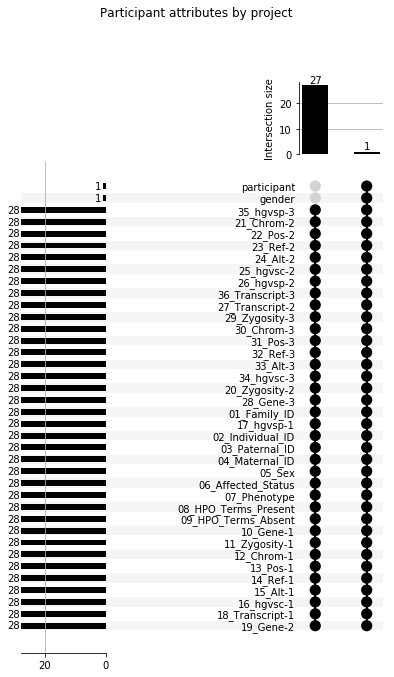

In [16]:
import matplotlib.pyplot
import pandas
import upsetplot

def upsetplot_attributes(project, entity):
    """Creates a dict useful for upsetplot"""
    d = {'project': project.project}
    d.update({n:True for n in sorted(project.schema[entity]['attributeNames'])})
    return d


attributes_df =  pandas.DataFrame([upsetplot_attributes(p, 'participant') for p in projects])

attributes = [c for c in attributes_df.columns if c != "project"]
attributes_count_series = attributes_df.fillna(False).groupby(attributes).count()["project"]

upsetplot.plot(attributes_count_series, sort_by="cardinality", show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Participant attributes by project')
current_figure.set_size_inches(6.5, 10.5)
current_figure.savefig("cmg_participant_attributes.png")


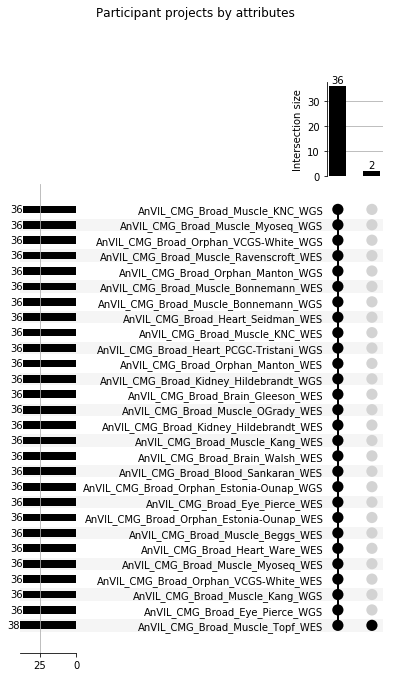

In [17]:
import matplotlib.pyplot
import pandas
import upsetplot

project_df =  pandas.DataFrame(upsetplot.from_contents({p.project: p.schema.participant.attributeNames for p in projects}))


upsetplot.plot(project_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Participant projects by attributes')
current_figure.set_size_inches(6.5, 10.5)
current_figure.savefig("cmg_participant_project.png")

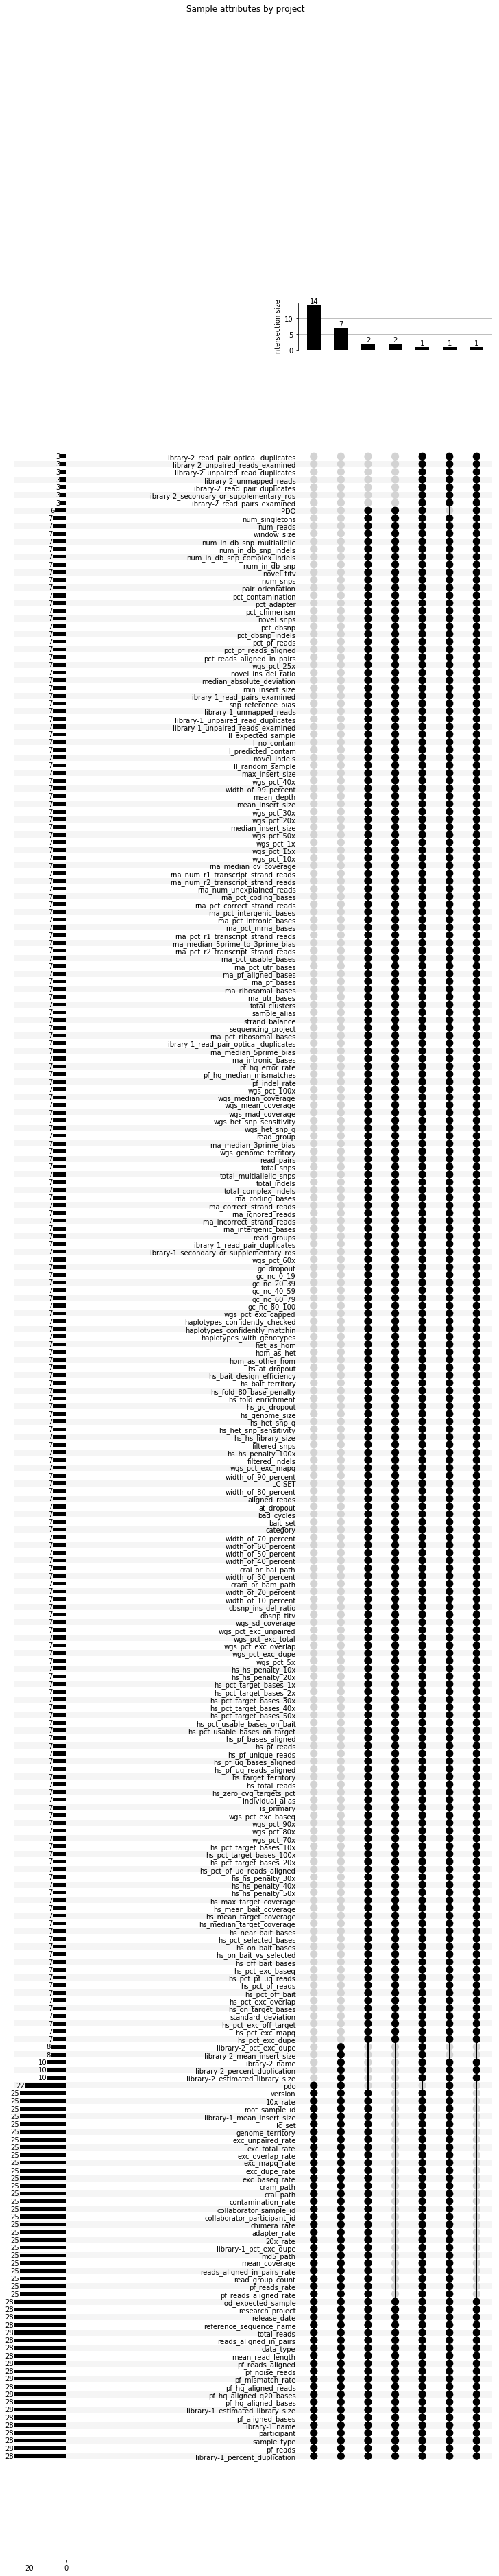

In [18]:
attributes_df =  pandas.DataFrame([upsetplot_attributes(p, 'sample') for p in projects])

attributes = [c for c in attributes_df.columns if c != "project"]
attributes_count_series = attributes_df.fillna(False).groupby(attributes).count()["project"]

upsetplot.plot(attributes_count_series, sort_by="cardinality", show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Sample attributes by project')
current_figure.set_size_inches(12.5, 60.5)
current_figure.savefig("cmg_sample_attributes.png")


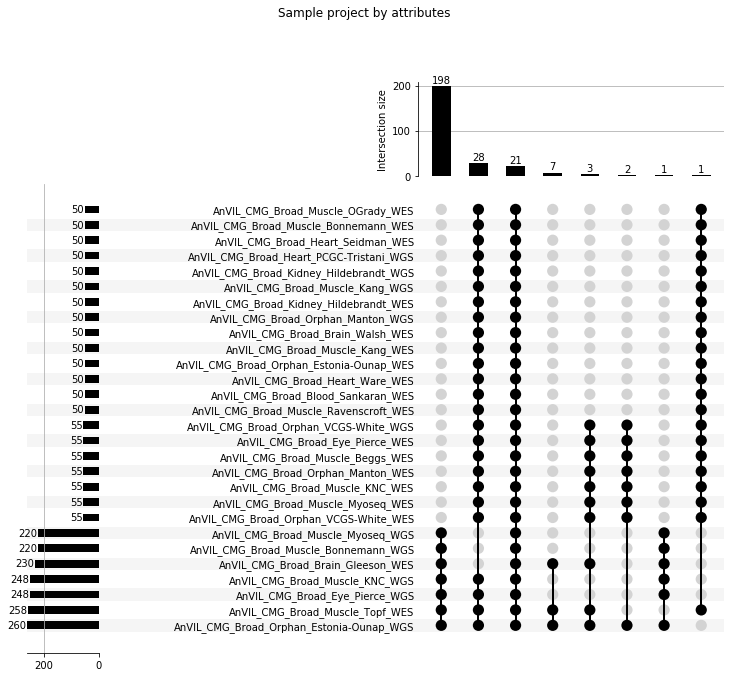

In [19]:
import matplotlib.pyplot
import pandas
import upsetplot

project_df =  pandas.DataFrame(upsetplot.from_contents({p.project: p.schema.sample.attributeNames for p in projects}))


upsetplot.plot(project_df, sort_by="cardinality", sum_over=False, show_counts='%d' ) # 
current_figure = matplotlib.pyplot.gcf()
current_figure.suptitle('Sample project by attributes')
current_figure.set_size_inches(12.5, 10.5)
current_figure.savefig("cmg_sample_project.png")

In [20]:
import firecloud.api as FAPI
from attrdict import AttrDict

def get_entities(namespace='anvil-datastorage', workspace=None, entity_name=None, fapi=FAPI):
  """returns all entities in a workspace"""
  entities = [AttrDict(e) for e in fapi.get_entities(namespace,workspace, entity_name).json()]
  return entities


all_participants = []
for p in projects:    
    participants = get_entities(namespace=p.program, workspace=p.project, entity_name='participant')
    assert len(participants) == p.schema.participant.count
    for participant in participants:
        attributes = participant.attributes
        attributes.submitter_id = participant.name
        attributes.project_id = '{}-{}'.format(p.program, p.project)
        all_participants.append(attributes)
print('all_participants', len(all_participants))

all_samples = []
for p in projects:
    samples = get_entities(namespace=p.program, workspace=p.project, entity_name='sample')
    assert len(samples) == p.schema.sample.count
    for sample in [sample for sample in samples if 'attributes' in sample]:
        attributes = sample.attributes
        attributes.project_id = '{}-{}'.format(p.program, p.project)
        submitter_id = '{}/{}'.format(
            attributes.project_id,
            attributes.get('sample_alias', attributes.get('collaborator_sample_id'))
        )        
        all_samples.append(attributes)
print('all_samples', len(all_samples))


all_participants 6224
all_samples 6228


In [21]:
participants_df =  pandas.DataFrame(all_participants)


In [22]:
import os

def file_md5(v):
    if not is_file(v):
        return None
    filename, file_extension = os.path.splitext(v)
    if file_extension == '.md5':
        return v
    return None


def file_type(v):
    if not is_file(v):
        return None
    filename, file_extension = os.path.splitext(v)
    if file_extension == '.md5':
        return None
    return file_extension

def is_file(v):
    if isinstance(v, str) and v.startswith('gs://'):
        return True
    return False


for s in all_samples:
    c = 0
    files = {}
    md5 = None
    paths = []
    for k,v in s.items():
        if is_file(v) and file_type(v):
            if v in paths:
                continue
            paths.append(v)    
            c += 1
            files[k] = AttrDict({'path':v, 'type': file_type(v)})
        if file_md5(v):
            md5 = v
    if md5:
        md5_filename, md5_file_extension =  os.path.splitext(md5)
        for k,f in files.items():
            if f.path == md5_filename:
                f.md5 = md5
    s.files = files
    # only library-1_name is consistent and uniq
    #library-1_name 6228 ['.crai', '.cram']
    #root_sample_id 3974 ['.crai', '.cram']
    #collaborator_sample_id 4464 ['.crai', '.cram']
    s.submitter_id = s['library-1_name']
    s.participant_id = s.participant.entityName

    
keys = ['library-1_name', 'root_sample_id', 'collaborator_sample_id']

for k in keys:
    print(k, 
          len(set([s.get(k, None) for s in all_samples])),
          [f.type for k,f in files.items()]
    ) 


library-1_name 6228 ['.crai', '.cram']
root_sample_id 3974 ['.crai', '.cram']
collaborator_sample_id 4464 ['.crai', '.cram']


In [26]:
#!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
G = nx.MultiDiGraph()

participant_mapping = {
    '01_Family_ID': 'family_id',
    '05_Sex': 'gender',
    'gender': 'gender',
    'submitter_id': 'submitter_id',
    '01_Family_ID': 'family_id',
    '02_Individual_ID': 'individual_id',
    '03_Paternal_ID': 'paternal_id',
    '04_Maternal_ID': 'maternal_id',
    '07_Phenotype': 'phenotype_id',
    '06_Affected_Status': 'affected_status',
    '08_HPO_Terms_Present': 'present',
    '09_HPO_Terms_Absent': 'absent',
    '10_Gene-1': 'gene',
    'project_id': 'project_id',
}


demographic_mapping = {
    '05_Sex': 'gender',
    'gender': 'gender',
    'eval:source["submitter_id"] + "_demographic"': 'submitter_id',
    
}

def map(source, target, mapping):
    """Maps source to target, controlled by mapping."""
    for source_key, target_key in mapping.items():
        # already set?
        if target_key in target and target[target_key]:
            continue
        if 'eval:' in source_key:
            val = target[target_key] = eval(source_key.replace('eval:',''), {'target': target, 'source': source})
        else:
            val = source.get(source_key, None)    
        if val == 'n/a':
            val = None
        if val:
            target[target_key] = val
    return target        


# lookup participant.submitter_id
family_lookup = {p['02_Individual_ID']:p['submitter_id'] for p in all_participants if '02_Individual_ID' in p}

phenotypes = set([participant['07_Phenotype'] for participant in all_participants if '07_Phenotype' in participant]) | \
    set([participant['08_HPO_Terms_Present'] for participant in all_participants if '08_HPO_Terms_Present' in participant]) | \
    set([participant['09_HPO_Terms_Absent'] for participant in all_participants if '09_HPO_Terms_Absent' in participant]) 
phenotypes = phenotypes - set([None, 'n/a'])


genes = set([participant['10_Gene-1'] for participant in all_participants if '10_Gene-1' in participant]) 
genes = genes - set([None, 'n/a'])


projects = set([participant.project_id for participant in all_participants]) 

for project in projects:
    G.add_node(project, label='Project', submitter_id=project)

    
for phenotype in phenotypes:
    G.add_node(phenotype, label='Phenotype', submitter_id=phenotype)

for gene in genes:
    G.add_node(gene, label='Gene', submitter_id=gene)

    
for participant in all_participants:
    subject = map(participant, AttrDict(), participant_mapping)
    assert subject.submitter_id, 'should have submitter_id'
    G.add_node(subject.submitter_id, label='Subject', **subject)
    if 'family_id' in subject:
        G.add_node(subject.family_id, label='Family')
    demographic = map(participant, AttrDict(), demographic_mapping)
    G.add_node(demographic.submitter_id, label='Demographic', **demographic)
    G.add_edge(subject.submitter_id, demographic.submitter_id, label='described_by')

        
        
for participant in all_participants:
    subject = map(participant, AttrDict(), participant_mapping)
    if 'family_id' in subject:
        G.add_edge(subject.submitter_id, subject.family_id, label='member_of')
    if 'paternal_id' in subject and subject.paternal_id in family_lookup:
        G.add_edge(subject.submitter_id, family_lookup[subject.paternal_id], label='father')
        G.add_edge(family_lookup[subject.paternal_id], subject.submitter_id, label='child')
    if 'maternal_id' in subject and subject.maternal_id in family_lookup:
        G.add_edge(subject.submitter_id, family_lookup[subject.maternal_id], label='mother')
        G.add_edge(family_lookup[subject.maternal_id], subject.submitter_id, label='child')
    if 'phenotype_id' in subject:
        diagnosis_id = '{}/{}'.format(subject.submitter_id, subject.phenotype_id)
        G.add_node(diagnosis_id, label='Diagnosis')
        G.add_edge(subject.submitter_id, diagnosis_id, label=subject.affected_status)
        G.add_edge(diagnosis_id, subject.phenotype_id, label='instance_of')
    if 'present' in subject:
        observation_id = '{}/{}'.format(subject.submitter_id, subject.present)
        G.add_node(observation_id, label='Observation')
        G.add_edge(subject.submitter_id, observation_id, label='present')
        G.add_edge(observation_id, subject.present, label='instance_of')
    if 'absent' in subject:
        observation_id = '{}/{}'.format(subject.submitter_id, subject.absent)
        G.add_node(observation_id, label='Observation')
        G.add_edge(subject.submitter_id, observation_id, label='absent')
        G.add_edge(observation_id, subject.absent, label='instance_of')
    if 'gene' in subject:
        G.add_edge(subject.submitter_id, subject.gene, label='expressed')
    G.add_edge(subject.submitter_id, subject.project_id, label='member_of')
                    

            
for sample in all_samples:
    G.add_node(sample.submitter_id, label='Sample')
    G.add_edge(sample.participant_id, sample.submitter_id, label='drawn_from')
    for k,file in sample.files.items():
        type = file.type.replace('.','').capitalize()
        G.add_node(file.path, label='{}File'.format(type))
        G.add_edge(sample.submitter_id, file.path, label=type)
        
    
        

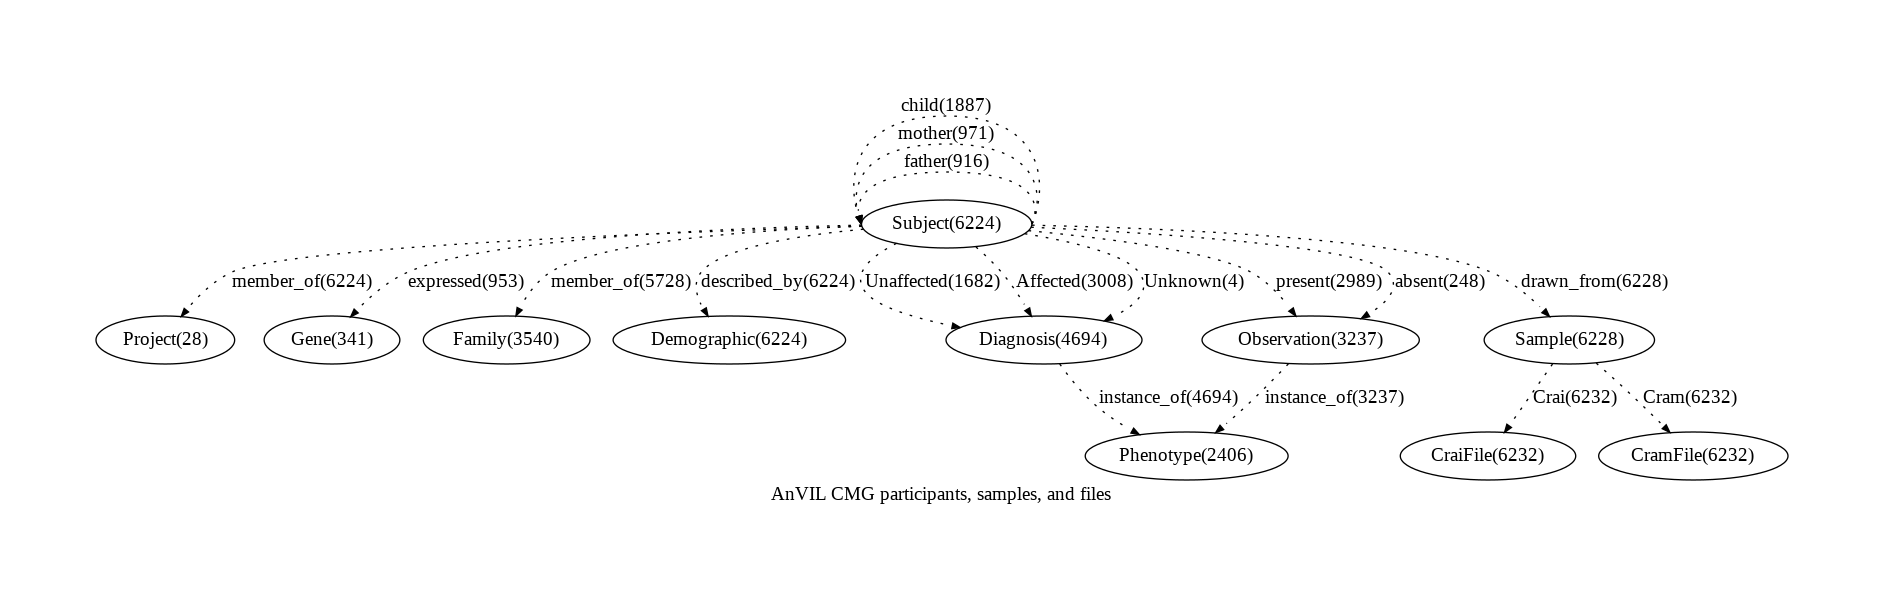

In [27]:
from IPython.display import Image
import pygraphviz

def summarize_graph(graph):
    """Introspects the data in the graph, creates a summary graph.  Relies on label attribute on each node"""
    # calc labels and edge lables
    labels = defaultdict(int)
    for k, v in graph.nodes.data():
        labels[v['label']] += 1
    for k, v in labels.items():
        labels[k] = '{}({})'.format(k, v)

    edge_labels = defaultdict(int)
    for n in graph.nodes():
        lable = graph.node[n]['label']
        for neighbor in graph.neighbors(n):
            n_lable = graph.node[neighbor]['label']
            edges = graph.get_edge_data(n, neighbor)
            for e in edges.values():
                edge_labels[(lable, n_lable, e['label'] )] += 1
    for k, v in edge_labels.items():
        edge_labels[k] = '{}'.format(v)

    # create new summary graph
    g = pygraphviz.AGraph(strict=False, directed=True)
    
    
    for k in labels:
        g.add_node(k, label=labels[k])

    compass_points = [('e','w')]        
            
    for k in edge_labels:
        start = k[0]
        end = k[1]
        key = k[2]
        # use compass points for self loops
        opts = {}
        if start == end:
            compass_point_offset = len([e for e in g.out_edges([start]) if e[1]==start]) % len(compass_points)
            compass_point = compass_points[compass_point_offset]
            opts = {'headport': compass_point[1], 'tailport': compass_point[0]}
        g.add_edge(start, end, label='{}({})'.format(k[2], edge_labels[k]), labeldistance=0,  **opts)

    return g


def draw_summary(g, label='<untitled>', prog='dot'):
    # ['dot', 'neato', 'twopi', 'circo', 'fdp', 'sfdp']
    g.layout(prog)                                                                 
    g.graph_attr.update(label=label, size = '40,40', pad=1) 
    g.edge_attr.update(arrowsize='0.6', style='dotted')
    g.graph_attr.update(scale=3) # , nodesep=1, ratio='auto')

    g.draw('{}.png'.format(label))  
    return Image('{}.png'.format(label))     


sumary_graph = summarize_graph(G)
draw_summary(sumary_graph,
             prog='dot',
             label='AnVIL CMG participants, samples, and files')


In [28]:
import json
from networkx.readwrite import json_graph
cmg_json = json_graph.node_link_data(G)
with open('bmeg_etl/notebooks/cmg_json.json', 'w') as outputs:
    json.dump(cmg_json, outputs)
    